Emotion detection model using Convolutional Neural Network and Transfer Learning using pretrained MobileNetv2 model.

Dataset that I have used is FER2013 dataset.

link of dataset: https://www.kaggle.com/datasets/gauravsharma99/fer13-cleaned-dataset

Importing the necessary libraries

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import tensorflow as tf
import cv2
import os
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,AveragePooling2D,GlobalMaxPool2D

Displaying a random image from dataset

In [2]:
img_arr= cv2.imread("/kaggle/input/fer13-even-more-cleaned-dataset/FER13_cleaner/train/happy/Training_10000426.jpg")
print(img_arr)

[[[ 24  24  24]
  [ 24  24  24]
  [ 68  68  68]
  ...
  [191 191 191]
  [183 183 183]
  [208 208 208]]

 [[ 22  22  22]
  [ 41  41  41]
  [111 111 111]
  ...
  [200 200 200]
  [184 184 184]
  [190 190 190]]

 [[ 28  28  28]
  [ 64  64  64]
  [152 152 152]
  ...
  [164 164 164]
  [173 173 173]
  [191 191 191]]

 ...

 [[155 155 155]
  [142 142 142]
  [142 142 142]
  ...
  [ 39  39  39]
  [ 51  51  51]
  [ 53  53  53]]

 [[ 93  93  93]
  [105 105 105]
  [ 75  75  75]
  ...
  [ 77  77  77]
  [ 58  58  58]
  [109 109 109]]

 [[ 13  13  13]
  [ 15  15  15]
  [ 11  11  11]
  ...
  [ 64  64  64]
  [ 66  66  66]
  [ 96  96  96]]]


In [3]:
img_arr.shape # rgb values 48px by 48px

(48, 48, 3)

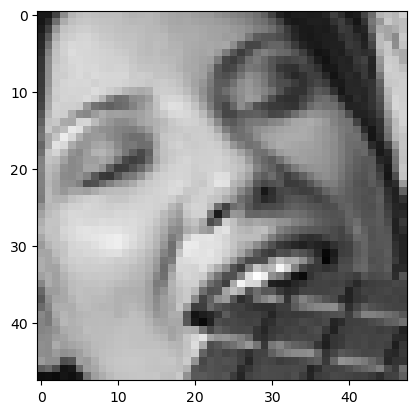

In [4]:
plt.imshow(img_arr)

In [5]:
classes=["angry","happy","neutral","surprise"] # list of classes

In [6]:
Datadirectory="/kaggle/input/fer13-even-more-cleaned-dataset/FER13_cleaner/train"

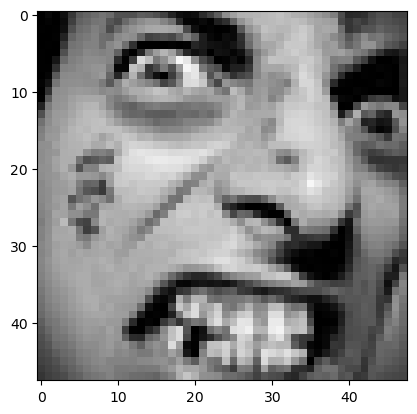

In [7]:
for category in classes:
    path=os.path.join(Datadirectory,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break


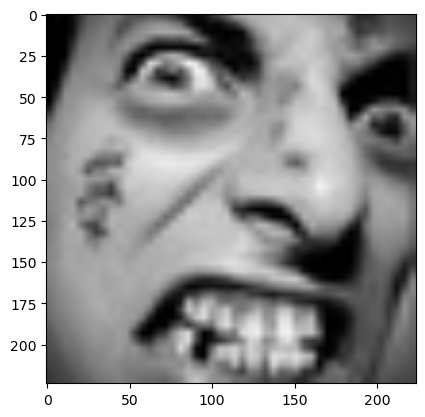

In [8]:
img_size= 224 # ImageNet -> 224 x 224
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_array.shape

(224, 224, 3)

Reading all the images and converting them into an array

In [10]:
training_data=[]
def create_training_data():
    for category in classes:
        cnt=0
        path=os.path.join(Datadirectory,category)
        class_num=classes.index(category)
        for img in os.listdir(path):
          if(cnt==3000):
            break

          cnt+=1

          try:
              img_array=cv2.imread(os.path.join(path,img))
              new_array=cv2.resize(img_array,(img_size,img_size))
              training_data.append([new_array,class_num])
          except Exception as e:
              pass



In [11]:
create_training_data()

In [13]:
print(len(training_data))

11832


In [14]:
# plt.imshow(training_data[2])

In [15]:
random.shuffle(training_data)

In [17]:
X = []
y = []

for feature, label in training_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [18]:
X.shape

(11832, 224, 224, 3)

In [19]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(X, y,test_size=0.20,random_state=42)

In [20]:
y[1748]

0

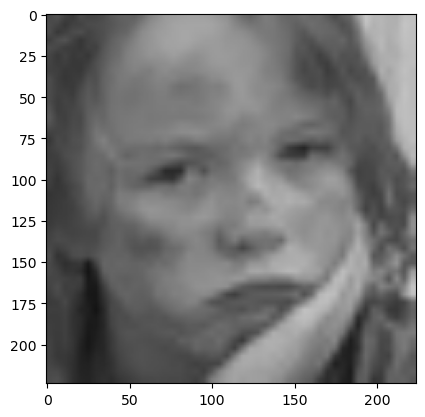

In [21]:
plt.imshow(X[1748])
plt.show()

Normalizing the data

In [22]:
trainX=trainX/255.0
testX=testX/255.0


TRANSFER LEARNING TO CREATE THE MODEL

Using the MobileNetv2 model for my purpose. The model was built to classify everyday objects into 1000 classes.
I will be using it to classify the 4 emotions

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2

In [24]:
base_model=MobileNetV2(weights='imagenet',input_shape=(224,224,3),include_top = False,classes=4)

Freezing the trainable parameters so as the weights dont change as the upper layers of the CNN model are general layers and I only need to modify the final few layers for my purpose

In [25]:
base_model.trainable=False

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Adding my own layers in the base model

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [51]:
prediction_layer = keras.layers.Dense(4,activation='softmax')

Adding new layers to the existing model for classifying 4 classes of sentiments

In [52]:
new_model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [63]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [64]:
new_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [65]:
hist=new_model.fit(trainX,trainY,epochs=20,batch_size=25,validation_data=(testX, testY),steps_per_epoch=len(trainX) / 25)

Epoch 1/20
378/378 [==============================] - 308s 802ms/step - loss: 1.0864 - accuracy: 0.5322 - val_loss: 0.9866 - val_accuracy: 0.5860
Epoch 2/20
378/378 [==============================] - 313s 827ms/step - loss: 0.9078 - accuracy: 0.6309 - val_loss: 0.9244 - val_accuracy: 0.6202
Epoch 3/20
378/378 [==============================] - 309s 817ms/step - loss: 0.8461 - accuracy: 0.6623 - val_loss: 0.9248 - val_accuracy: 0.6215
Epoch 4/20
378/378 [==============================] - 326s 861ms/step - loss: 0.8156 - accuracy: 0.6792 - val_loss: 0.9201 - val_accuracy: 0.6219
Epoch 5/20
378/378 [==============================] - 327s 863ms/step - loss: 0.7875 - accuracy: 0.6905 - val_loss: 0.8928 - val_accuracy: 0.6460
Epoch 6/20
378/378 [==============================] - 306s 808ms/step - loss: 0.7687 - accuracy: 0.6967 - val_loss: 0.9030 - val_accuracy: 0.6405
Epoch 7/20
378/378 [==============================] - 327s 864ms/step - loss: 0.7467 - accuracy: 0.7066 - val_loss: 0.8950 -

In [66]:
new_model.save('final_model.h5')

Evaluating the model

In [67]:
loss,accuracy=new_model.evaluate(testX,testY)
print(loss)
print(accuracy)

74/74 [==============================] - 61s 823ms/step - loss: 0.9160 - accuracy: 0.6510
0.9159795045852661
0.6510350704193115


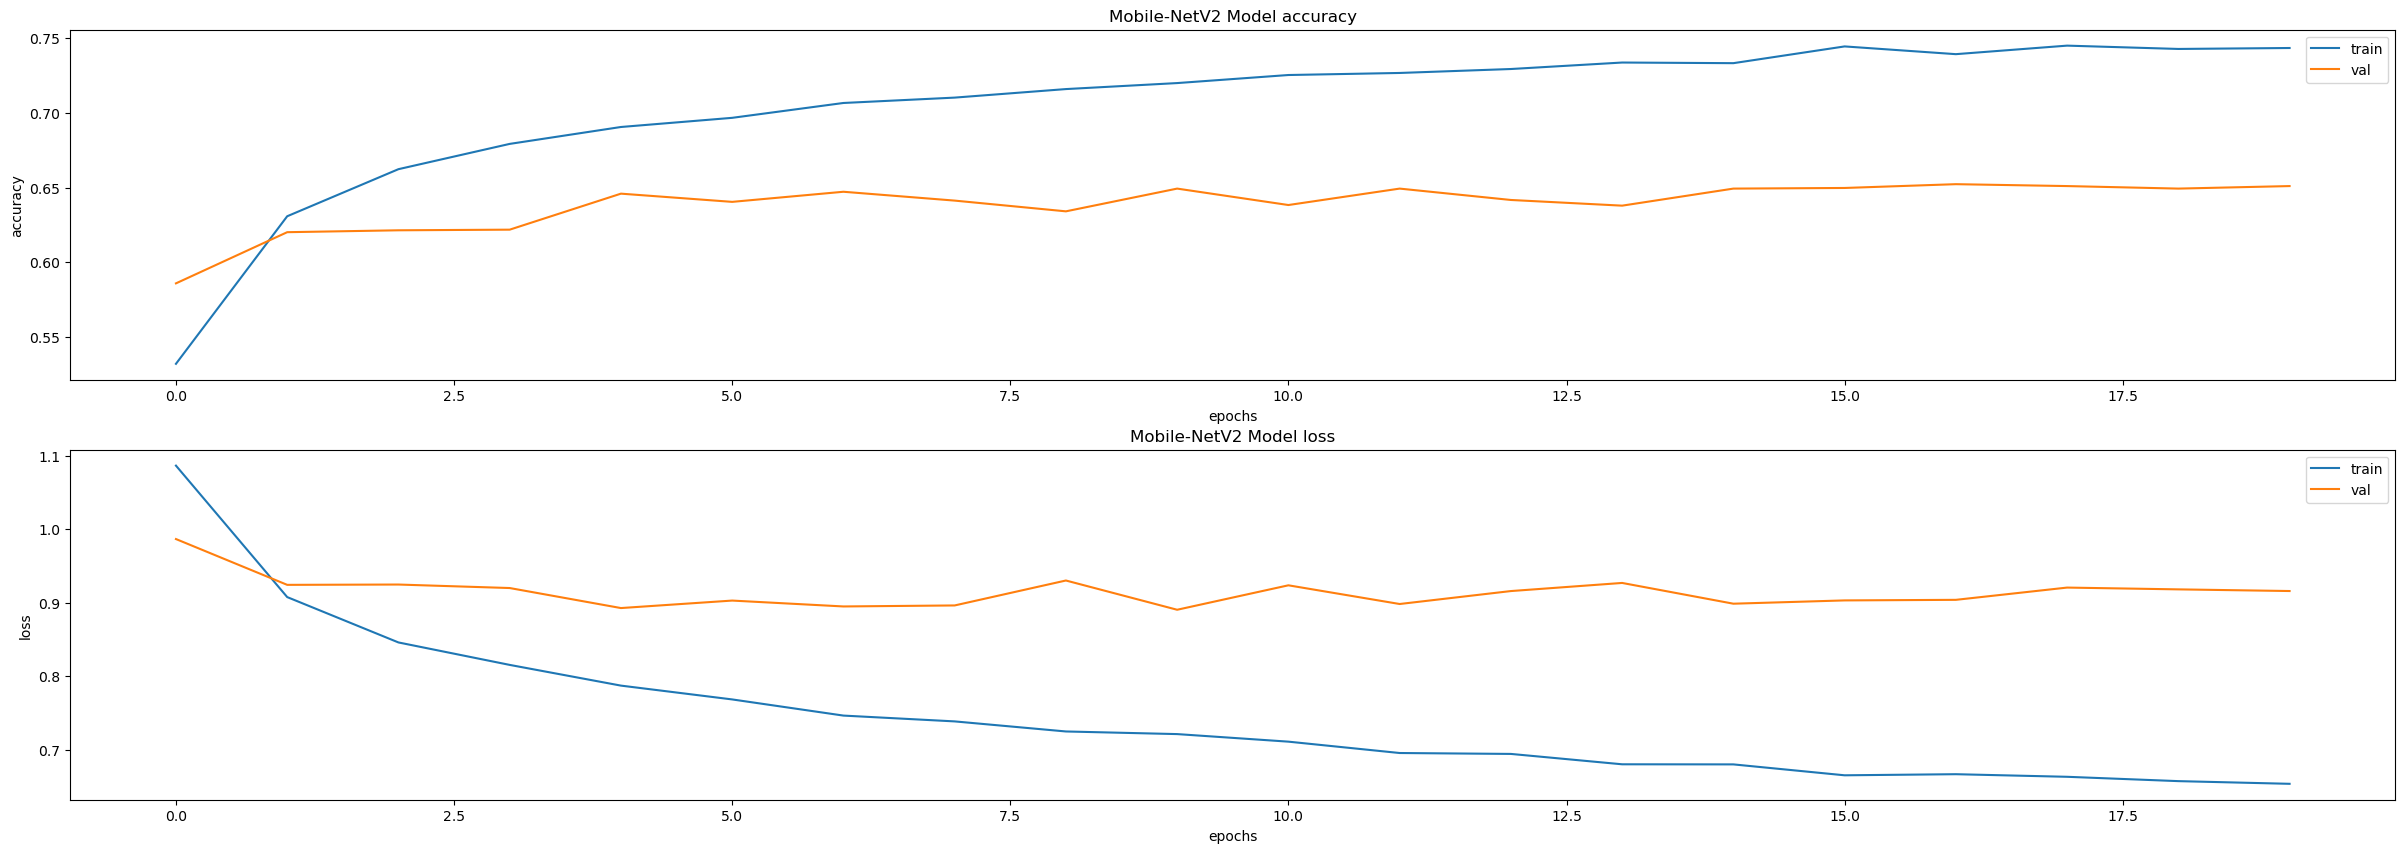

In [68]:
# Interpreting the Metrics
fig, ax = plt.subplots(2, 1, figsize=(30, 10))
ax = ax.ravel()

#for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Mobile-NetV2 Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [69]:
loaded_model=tf.keras.models.load_model('final_model.h5')

In [70]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


Checking the prediction of the model

In [104]:
test_img=cv2.imread('/kaggle/input/fer13-even-more-cleaned-dataset/FER13_cleaner/test/surprise/PrivateTest_14204552.jpg')
test_img.shape

(48, 48, 3)

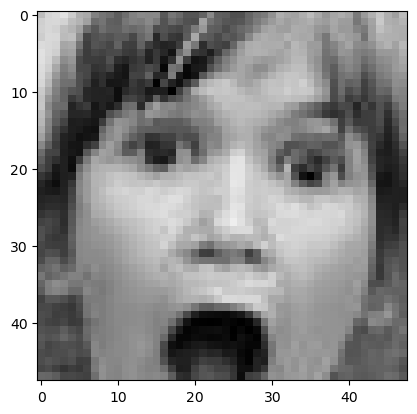

In [105]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

Let's see if the model can accurately predict the emotion of the image

In [106]:
final_image=cv2.resize(test_img, (224,224)) # resizing the image to fit it in the model
final_image=np.expand_dims(final_image,axis=0) # need the fourth dimension

In [107]:
final_image.shape

(1, 224, 224, 3)

In [108]:
final_image=final_image/255.0 #normalizing the data

In [109]:
prediction=loaded_model.predict(final_image)

1/1 [==============================] - 0s 67ms/step


In [110]:
prediction[0]

array([0.05656704, 0.01052168, 0.02727218, 0.9056391 ], dtype=float32)

In [111]:
classes[np.argmax([prediction])]

'surprise'